In [1]:
import pandas as pd
import wget

In [2]:
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR" -O articles.csv && rm -rf /tmp/cookies.txt 
#!wget 'https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a' -O users_articles.csv

In [3]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [4]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [5]:
!pip install razdel pymorphy2

You should consider upgrading via the 'C:\Users\Pokerstar\PycharmProjects\helloworld\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [6]:
!pip install gensim

You should consider upgrading via the 'C:\Users\Pokerstar\PycharmProjects\helloworld\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [7]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

In [8]:
!pip install nltk

You should consider upgrading via the 'C:\Users\Pokerstar\PycharmProjects\helloworld\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pokerstar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

151


In [11]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [12]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [13]:
!pip install tqdm

You should consider upgrading via the 'C:\Users\Pokerstar\PycharmProjects\helloworld\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [14]:
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста. Будет долго...
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

  0%|                                                                                                                                    | 0/27000 [00:00<?, ?it/s]C:\Users\Pokerstar\AppData\Local\Temp\ipykernel_1804\4083466619.py:14: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27000/27000 [00:38<00:00, 695.84it/s]


In [15]:
news['title'].iloc[:10]

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
2    форвард авангарда томаш заборский прокомментир...
3    главный тренер кубани юрий красножан прокоммен...
4    решением попечительского совета владивостокско...
5    ио главного тренера вячеслав буцаев прокоммент...
6    запорожский металлург дома потерпел разгромное...
7    сборная сша одержала победу над австрией со сч...
8    бывший защитник сборной россии дарюс каспарайт...
9    полузащитник цска зоран тошич после победы над...
Name: title, dtype: object

In [16]:
# Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27000/27000 [05:08<00:00, 87.51it/s]


In [17]:
news['title'][:10]

0    [заместитель, председатель, правительство, рф,...
1    [матч, финал, кубок, россия, футбол, приостано...
2    [форвард, авангард, томаш, заборский, прокомме...
3    [главный, тренер, кубань, юрий, красножанин, п...
4    [решение, попечительский, совет, владивостокск...
5    [ио, главное, тренер, вячеслав, буцай, прокомм...
6    [запорожский, металлург, дом, потерпеть, разгр...
7    [сборная, сша, одержать, победа, австрия, счёт...
8    [бывший, защитник, сборная, россия, дарюс, кас...
9    [полузащитник, цска, зоран, тошич, победа, тер...
Name: title, dtype: object

In [18]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [19]:
len(common_dictionary)

135723

In [20]:
#common_dictionary.id2token

In [21]:
N_topic = 20  # можно было менять

In [ ]:
#!pip install gensim

In [22]:
from gensim.models import LdaModel

# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, passes=2)  # можно было менять

In [23]:
from gensim.test.utils import datapath

# Сохраняем модель на диск
temp_file = datapath("model.lda")
lda.save(temp_file)

In [24]:
# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [25]:
# Создаем новый корпус документов, которые раньше не видели
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(3, 0.22437641), (14, 0.17380221), (18, 0.5827575)]

In [26]:
x = lda.show_topics(num_topics=N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: смерть пациент температура журнал лечение градус умереть
topic_1: который это дело год суд фонд человек
topic_2: банк депутат выборы партия госдума кандидат компьютерный
topic_3: это который ракета погибнуть свой помощь год
topic_4: это мочь который россия президент год цена
topic_5: сша американский санкция доллар китай северный россия
topic_6: год это млрд проект который новый российский
topic_7: млн газ год рубль тыс составить сумма
topic_8: восток высота дональд экипаж франция греция пострадать
topic_9: год который это исследование первый стать научный
topic_10: ребёнок гражданин журнал фронт народный родитель долг
topic_11: военный армия сила миссия боевой оборона журнал
topic_12: человек наука это статья свой который жизнь
topic_13: украина украинский киев рейс больной японский россия
topic_14: год напомнить британский сообщать мозг топливо стать
topic_15: человек обнаружить время который произойти женщина результат
topic_16: турция турецкий виза диапазон свидетель умира

In [27]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [28]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.        , 0.06663912, 0.26566359, 0.        , 0.        ,
       0.        , 0.11801694, 0.        , 0.        , 0.13100098,
       0.30065989, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.11134357, 0.        ])

In [29]:
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.06662,0.265670,0.000000,0.00000,0.0,0.118043,0.0,0.0,...,0.300666,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.111345,0.0
1,4896,0.0,0.00000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.544881,0.0,0.0,0.432605,0.0
2,4897,0.0,0.00000,0.000000,0.224346,0.00000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.173885,0.000000,0.0,0.0,0.582705,0.0
3,4898,0.0,0.00000,0.028511,0.000000,0.16424,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.796997,0.0
4,4899,0.0,0.00000,0.268852,0.000000,0.00000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.110821,0.0


In [30]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [31]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [32]:
doc_dict[293672]

array([0.0486249 , 0.        , 0.        , 0.03699241, 0.07376951,
       0.02737506, 0.39514548, 0.        , 0.        , 0.40252799,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [33]:
def get_user_embedding(user_articles_list, doc_dict, func):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = func(user_vector, axis=0)
    return user_vector

In [34]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding(user_articles_list, doc_dict, np.mean)

array([0.02143814, 0.17075959, 0.06696051, 0.04352334, 0.28195985,
       0.04710316, 0.05781512, 0.00532682, 0.00638229, 0.10921064,
       0.0078281 , 0.046579  , 0.05235135, 0.        , 0.02011815,
       0.04766644, 0.        , 0.        , 0.0067536 , 0.        ])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [35]:
FUNC = np.mean # 

In [36]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, FUNC))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.008104,0.104100,0.000000,0.126170,0.061942,0.018805,0.157990,0.003165,0.010416,...,0.044363,0.009758,0.042658,0.070601,0.080376,0.028438,0.002246,0.002555,0.002906,0.01126
1,u108690,0.000000,0.183341,0.005007,0.124435,0.276980,0.023611,0.054157,0.024574,0.014436,...,0.023123,0.006466,0.039965,0.068343,0.014251,0.032949,0.000000,0.000000,0.020439,0.00000
2,u108339,0.027206,0.226786,0.011857,0.138163,0.114397,0.011652,0.081949,0.020713,0.006027,...,0.034161,0.013562,0.003802,0.000000,0.042086,0.149455,0.000000,0.002978,0.003377,0.00000


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [37]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [38]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.008104,0.104100,0.000000,0.126170,0.061942,0.018805,0.157990,0.003165,0.010416,...,0.009758,0.042658,0.070601,0.080376,0.028438,0.002246,0.002555,0.002906,0.01126,0
1,u108690,0.000000,0.183341,0.005007,0.124435,0.276980,0.023611,0.054157,0.024574,0.014436,...,0.006466,0.039965,0.068343,0.014251,0.032949,0.000000,0.000000,0.020439,0.00000,1
2,u108339,0.027206,0.226786,0.011857,0.138163,0.114397,0.011652,0.081949,0.020713,0.006027,...,0.013562,0.003802,0.000000,0.042086,0.149455,0.000000,0.002978,0.003377,0.00000,1


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [40]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [41]:
model = LogisticRegression()
# обучим 
model.fit(X_train, y_train)

LogisticRegression()

In [42]:
# наши прогнозы для тестовой выборки
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.11497795, 0.02183089, 0.54503858, 0.23521373, 0.03920284,
       0.04577174, 0.15538158, 0.01172524, 0.07391105, 0.1212114 ])

In [43]:
metrics_df = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC


In [44]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

In [45]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.2634329664735953, F-Score=0.716, Precision=0.650, Recall=0.796


In [46]:
!pip install more-itertools

You should consider upgrading via the 'C:\Users\Pokerstar\PycharmProjects\helloworld\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [47]:
import itertools as itertools

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1650  105]
 [  51  194]]


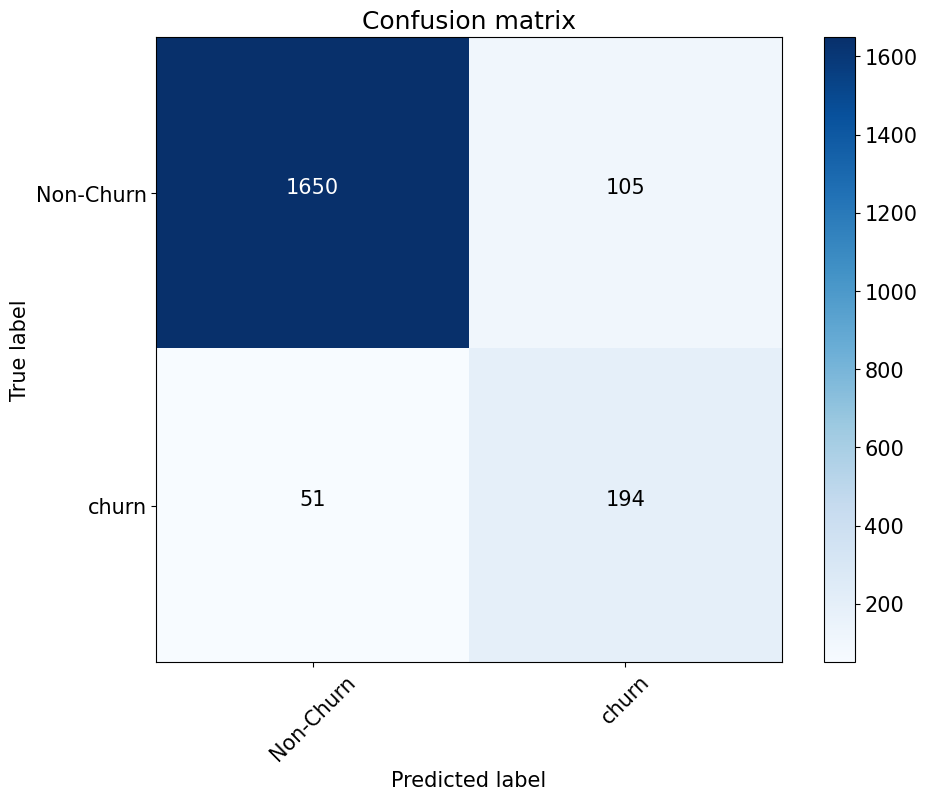

In [49]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [50]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9554485725914297

In [51]:
metrics_df = metrics_df.append({
    'model': FUNC.__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

metrics_df

C:\Users\Pokerstar\AppData\Local\Temp\ipykernel_1804\1288159249.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.263433,0.715596,0.65,0.795918,0.955449


Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [52]:
FUNC = np.median

In [53]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, FUNC))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.050677,0.0,0.094936,0.036885,0.0,0.068639,0.000000,0.000000,...,0.016282,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,u108690,0.000000,0.123267,0.0,0.143534,0.264610,0.0,0.036158,0.000000,0.007881,...,0.009351,0.0,0.036801,0.029995,0.007619,0.000000,0.0,0.0,0.0,0.0
2,u108339,0.010998,0.280445,0.0,0.133103,0.079973,0.0,0.091165,0.007236,0.000000,...,0.018207,0.0,0.000000,0.000000,0.030505,0.080295,0.0,0.0,0.0,0.0


In [54]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.050677,0.0,0.094936,0.036885,0.0,0.068639,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
1,u108690,0.000000,0.123267,0.0,0.143534,0.264610,0.0,0.036158,0.000000,0.007881,...,0.0,0.036801,0.029995,0.007619,0.000000,0.0,0.0,0.0,0.0,1
2,u108339,0.010998,0.280445,0.0,0.133103,0.079973,0.0,0.091165,0.007236,0.000000,...,0.0,0.000000,0.000000,0.030505,0.080295,0.0,0.0,0.0,0.0,1


In [55]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [56]:
model = LogisticRegression()
# обучим 
model.fit(X_train, y_train)

LogisticRegression()

In [57]:
# наши прогнозы для тестовой выборки
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.16360861, 0.00850082, 0.5961376 , 0.13256255, 0.02654308,
       0.02778646, 0.14786793, 0.0163202 , 0.08051696, 0.09045198])

In [58]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.3071277402355299, F-Score=0.741, Precision=0.760, Recall=0.722


In [59]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9656049770335485

In [60]:
metrics_df = metrics_df.append({
    'model': FUNC.__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

metrics_df

C:\Users\Pokerstar\AppData\Local\Temp\ipykernel_1804\1288159249.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.263433,0.715596,0.650000,0.795918,0.955449
1,median,0.307128,0.740586,0.759657,0.722449,0.965605


Повторить п.2, но используя уже не медиану, а max

In [61]:
FUNC = np.max

In [62]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, FUNC))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.048625,0.311918,0.000000,0.328959,0.210513,0.085457,0.415514,0.018991,0.040176,...,0.147872,0.038063,0.220338,0.423608,0.241698,0.170629,0.013478,0.015329,0.017434,0.036729
1,u108690,0.000000,0.480095,0.017005,0.176512,0.552111,0.081367,0.128766,0.147442,0.036712,...,0.092252,0.026457,0.103931,0.191681,0.041625,0.111117,0.000000,0.000000,0.066093,0.000000
2,u108339,0.109479,0.377053,0.052469,0.238350,0.331640,0.069911,0.162396,0.069698,0.019179,...,0.095389,0.081370,0.012273,0.000000,0.134351,0.433060,0.000000,0.017868,0.020261,0.000000


In [63]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.048625,0.311918,0.000000,0.328959,0.210513,0.085457,0.415514,0.018991,0.040176,...,0.038063,0.220338,0.423608,0.241698,0.170629,0.013478,0.015329,0.017434,0.036729,0
1,u108690,0.000000,0.480095,0.017005,0.176512,0.552111,0.081367,0.128766,0.147442,0.036712,...,0.026457,0.103931,0.191681,0.041625,0.111117,0.000000,0.000000,0.066093,0.000000,1
2,u108339,0.109479,0.377053,0.052469,0.238350,0.331640,0.069911,0.162396,0.069698,0.019179,...,0.081370,0.012273,0.000000,0.134351,0.433060,0.000000,0.017868,0.020261,0.000000,1


In [64]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [65]:
model = LogisticRegression()
# обучим 
model.fit(X_train, y_train)

LogisticRegression()

In [66]:
# наши прогнозы для тестовой выборки
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.07179675, 0.00123642, 0.8374479 , 0.37995078, 0.00362896,
       0.00207756, 0.01227937, 0.00445841, 0.02125961, 0.12241202])

In [67]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.37512701229307616, F-Score=0.801, Precision=0.814, Recall=0.788


In [68]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9730193615907903

In [69]:
metrics_df = metrics_df.append({
    'model': FUNC.__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

metrics_df

C:\Users\Pokerstar\AppData\Local\Temp\ipykernel_1804\1288159249.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.263433,0.715596,0.650000,0.795918,0.955449
1,median,0.307128,0.740586,0.759657,0.722449,0.965605
2,amax,0.375127,0.800830,0.814346,0.787755,0.973019


(опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [71]:
users['articles_str'] = users['articles'].apply(lambda x: x.replace('[','').replace(']', '').replace(',', ''))

users['articles_str'].iloc[0]

'293672 293328 293001 293622 293126 1852'

In [72]:
tfidf = TfidfVectorizer()
tfidf.fit(users['articles_str'])

TfidfVectorizer()

In [73]:
idf = pd.DataFrame({'article_id': tfidf.get_feature_names_out(),
                    'idf': tfidf.idf_})

idf

,article_id,idf
0,10,8.888710
1,100,7.907880
2,1000,8.041412
3,1001,8.888710
4,1002,8.888710
...,...,...
14776,995,8.377884
14777,996,8.195562
14778,997,8.601027
14779,998,9.294175


In [74]:
def get_user_embedding_idf(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    
    user_vector = np.zeros((len(user_articles_list), N_topic))
    for i, doc_id in enumerate(user_articles_list):
        try:
            weight = idf[idf['article_id'] == str(doc_id)]['idf'].values[0]
        except Exception as e:
            weight = 0
        user_vector[i] = doc_dict[doc_id] * weight

    user_vector = np.median(user_vector, axis=0)
    return user_vector

In [75]:
from tqdm import tqdm
tqdm.pandas()

user_embeddings = pd.DataFrame([i for i in users['articles'].progress_apply(lambda x: get_user_embedding_idf(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:25<00:00, 94.03it/s]


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.471003,0.0,0.807714,0.317247,0.0,0.590368,0.000000,0.000000,...,0.140041,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,u108690,0.000000,0.984852,0.0,1.248623,2.273923,0.0,0.313094,0.000000,0.070052,...,0.086911,0.0,0.312456,0.266621,0.067721,0.000000,0.0,0.0,0.0,0.0
2,u108339,0.102214,2.269272,0.0,1.131325,0.652832,0.0,0.806797,0.059302,0.000000,...,0.169216,0.0,0.000000,0.000000,0.256689,0.665284,0.0,0.0,0.0,0.0


In [76]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.471003,0.0,0.807714,0.317247,0.0,0.590368,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
1,u108690,0.000000,0.984852,0.0,1.248623,2.273923,0.0,0.313094,0.000000,0.070052,...,0.0,0.312456,0.266621,0.067721,0.000000,0.0,0.0,0.0,0.0,1
2,u108339,0.102214,2.269272,0.0,1.131325,0.652832,0.0,0.806797,0.059302,0.000000,...,0.0,0.000000,0.000000,0.256689,0.665284,0.0,0.0,0.0,0.0,1


In [77]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [78]:
model = LogisticRegression()
# обучим 
model.fit(X_train, y_train)

LogisticRegression()

In [79]:
# наши прогнозы для тестовой выборки
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([1.40388752e-01, 3.07820618e-06, 9.46146869e-01, 3.36022355e-02,
       1.47798930e-04, 2.43313985e-04, 5.37027473e-02, 6.90140425e-04,
       2.59161129e-02, 1.54204115e-02])

In [80]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.40862876843618734, F-Score=0.841, Precision=0.819, Recall=0.865


In [81]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9859363916506774

In [82]:
metrics_df = metrics_df.append({
    'model': 'idf_median',
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

C:\Users\Pokerstar\AppData\Local\Temp\ipykernel_1804\1015548053.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [83]:
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.263433,0.715596,0.650000,0.795918,0.955449
1,median,0.307128,0.740586,0.759657,0.722449,0.965605
2,amax,0.375127,0.800830,0.814346,0.787755,0.973019
3,idf_median,0.408629,0.841270,0.818533,0.865306,0.985936


Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

если брать idf_median, то мы не находим лишь 10% желающих уйти в отток (Recall = 0.865306), минимально считаем лишних людей, которые на самом деле не хотели уходить (Precision = 0.818533), собственно мы видим, что данный способ имеет на выходе максимальный F-score = 0.841270

### TF IDF
TF - частота слова - отношение числа вхождений некоторого слова к общему числу слов документа. Таким образом, оценивается важность слова в пределах отдельного документа. IDF - обратная частота документа - инверсия частоты, с которой некоторое слово встречается в документах коллекции.

Большой вес в TF-IDF получат слова с высокой частотой в пределах конкретного документа и с низкой частотой употреблений в других документах. То есть, если мы имеем корпус с текстами с сильно различным количеством слов, мы рискуем получить завышенный показатель IDF если слово встречается только в маленьких текстах и наоборот если слово часто встречается много раз только в одном крупном тексте.

Получается, что взвешивание по tfidf максимально точно помогло построить вектора пользователей.

Если же не брать TFIDF метод, то лучшим будет результат с использованием $MAX$